In [29]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage 

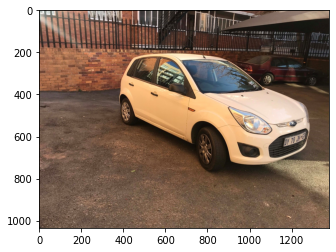

In [2]:
img = cv2.imread("img/test_car.jpg")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)

In [3]:
x, y, w, h = np.repeat(0, 4)

In [4]:
mouse_click = False
show_img = np.copy(img)

In [5]:
## Defining a call back function to draw a rectangle
def mouseCallBack(event, x_, y_, flag, pram):
    # declearing global variables sothat it wont show errors
    global x, y, w, h, mouse_click, show_img
    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_click = True
        # giving x and y the current coordinate
        x, y = x_, y_
        # reseting the show_img
        show_img = np.copy(img)

    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_click:
            # reseting th image
            show_img = np.copy(img)
            # drawing a rectangle on image
            cv2.rectangle(show_img, (x, y), (x_, y_), (0, 255, 0), 2)

    elif event == cv2.EVENT_LBUTTONUP:
        mouse_click = False
        #giving the coordinates of to width and height
        w, h = x_, y_

In [6]:
cv2.namedWindow("CAR")
cv2.setMouseCallback("CAR", mouseCallBack)

while(1):
    
    cv2.imshow('CAR', show_img)
    
    cv2.setMouseCallback("CAR", mouseCallBack)

    if cv2.waitKey(1) == ord('q') and not mouse_click:
        if w*h > 0:
            break
cv2.destroyAllWindows()

In [7]:
# this small code allows us to make rectangle from any diretion without an errer
if x > w:
    x, w = w, x
if y > h:
    y, h = h, y
# displaying the new values of x, y, w, h
x, y, w, h

(348, 195, 1313, 778)

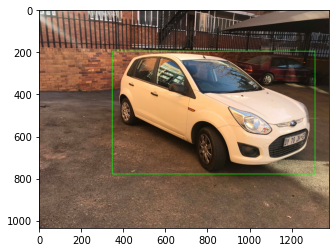

In [8]:
plt.imshow(cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB))

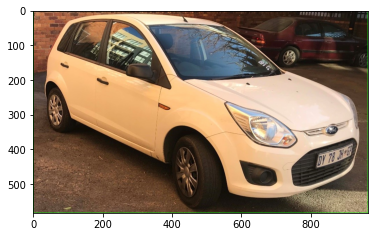

In [9]:
plt.imshow(cv2.cvtColor(show_img[y:h, x:w], cv2.COLOR_BGR2RGB))

In [10]:
foreground = False
background = False
drawing = False
brush_size = 10
fg_color=(0, 255, 0)
bg_color=(0, 0, 255)

In [11]:
%%time
## Applying Grabcut model
show_img = np.copy(img)
mask = np.zeros(show_img.shape[:2],np.uint8)
bg_Model = np.zeros((1,65),np.float64)
fg_Model = np.zeros((1,65),np.float64)

mask, bg_Model, fg_Model = cv2.grabCut(show_img, mask, (x, y, w, h), bg_Model, fg_Model, 1, cv2.GC_INIT_WITH_RECT)

Wall time: 10 s


Wall time: 228 ms


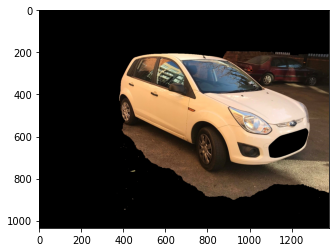

In [12]:
%%time
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
new_img = show_img*mask2[:,:,np.newaxis]
plt.imshow(new_img[:,:,::-1])

In [13]:
# it is a function to select the foregroung and backgtround and mprove the mask image
def select_fg_bg(event, _x, _y, flags, pram):
    global foreground, background, drawing, brush_size, fg_color, bg_color, color, new_img
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True 
        
        if foreground: 
            color = fg_color
            # drawing the circles with the radius equal to size of brush on the clicked coordinates
            cv2.circle(new_img,(_x, _y), brush_size, color, -1)
            # converting the marked coordinate to foreground 
            mask[_y - brush_size : _y + brush_size, _x - brush_size : _x + brush_size] = 1
        
        elif background:
            color = bg_color
            # drawing the circles with the radius equal to size of brush on the clicked coordinates
            cv2.circle(new_img,(_x, _y), brush_size, color, -1)
            # converting the marked coordinate to background 
            mask[ _y - brush_size : _y + brush_size, _x - brush_size : _x + brush_size] = 0
    
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            
            if foreground:
                # continuously drawing the circles with the radius equal to size of brush
                # with the movement of mouse
                cv2.circle(new_img,(_x, _y), brush_size, color, -1)
                # converting the marked coordinate to background
                mask[_y - brush_size : _y + brush_size, _x - brush_size : _x + brush_size] = 1
            
            elif background:
                # continuously drawing the circles with the radius equal to size of brush
                # with the movement of mouse
                cv2.circle(new_img,(_x, _y), brush_size, color, -1)
                # converting the marked coordinate to background
                mask[_y - brush_size : _y + brush_size, _x - brush_size : _x + brush_size] = 0
    
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False            

In [14]:

"""
        allow user to choose foreground and background
        
        useful keys:
        f: choose foreground. on the segmented image, click and drag on region of interest.
            Selected area will become green (default).
        b: choose background. on the segmented image, click and drag on region of interest.
            Selected area will become red (default).
        r: rerun grabcut iteration.
        spacebar: end grabcut iteration.
        =: increase brush size
        -: decrease brush size
        
        2 images will be generated: original image with bounding box and segmented image. Useful keys can only be 
        used on segmented image window.
        
        upon spacebar key (end grabcut iteration), final segmented image will be returned.
"""
        
cv2.namedWindow('original image')
cv2.namedWindow('image')
        
while(1):
        
    cv2.imshow('image', new_img)
    cv2.imshow('original image', show_img)
    cv2.setMouseCallback('image', select_fg_bg)

    key = cv2.waitKey(1)
            
    if key == ord('f'):
        foreground = True
        background = False
        
    elif key == ord('b'):
        foreground = False
        background = True
        
    elif key == ord('r'): #reiterate grabcut with selected foreground and background
        background = False
        foreground = False
        _ = cv2.grabCut(show_img, mask, None, bg_Model,
                          fg_Model, 1, cv2.GC_INIT_WITH_MASK)
                
        mask3 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
            
        new_img = img*mask3[:,:, np.newaxis]
        
    elif key == ord('+'): #increase brush size
        foreground = False
        background = False
        brush_size += 2
        
    elif key == ord('-'): #decrease brush size
        foreground = False
        background = False

        brush_size -= 2
                   
    elif key == ord (' '): #space bar to end
        cv2.destroyAllWindows()
        break
        

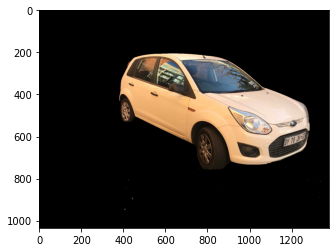

In [15]:
# converting new_img from BGR to RGB
plt.imshow(new_img[:,:,::-1])

In [16]:
ones = np.ones(new_img.shape)

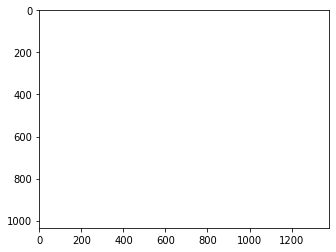

In [17]:
plt.imshow(ones)

In [18]:
final_img = np.copy(new_img)

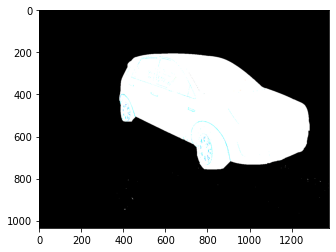

In [19]:
# Ploting the mask image
final_mask = final_img
final_mask[final_img !=0] = 255
plt.imshow(final_mask)

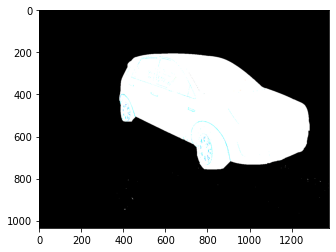

In [20]:
# Rounding off the image to get more clear picture
final_mask = np.round(final_mask)
plt.imshow(final_mask)

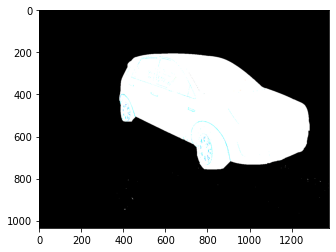

In [21]:
# Normalizing so that we get only 0 and 1 values left
final_mask = final_mask/255
plt.imshow(final_mask)

In [22]:
np.unique(final_mask)

array([0., 1.])

In [23]:
# Inverting the mask image
final_mask[final_mask == 0], final_mask[final_mask == 1], final_mask[final_mask == 2] = 2, 0, 1

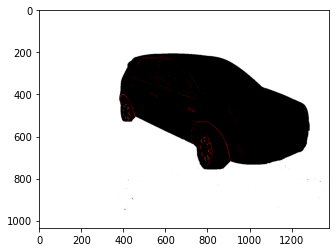

In [24]:
plt.imshow(final_mask)

In [25]:
result = np.copy(img[:,:,::-1])

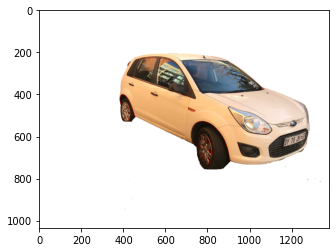

In [26]:
# Generating final output
result[final_mask != 0] = 255
plt.imshow(result)